# Hands-on Machine Learning
# Chapter 4 - Training Models

## Setup

In [38]:
# Is Python version at least 3.5?
import sys
assert sys.version_info >= (3, 5)

# Is sklearn at least version 0.2?
import sklearn
assert sklearn.__version__  >= "0.20"

# Helper libraries
import numpy as np
import pandas as pd

# Matplotlib setup 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings for this notebook
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

In [39]:
# Directory for storing images
import os
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = '04_training_linear_models'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [40]:
# Function save images
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Example 1 - Normal Equation and Linear Models
The normal equation provides a closed-form solution for minimising the parameter values $\theta$ of a linear model to minimise the mean square error between the model's predictions $y'$ and $y$.

In [5]:
np.random.seed(42)

In [6]:
# Create a domain of 100 random values between 0 and 1
X = 2 * np.random.rand(100, 1)

# Use this domain to create a linear sum with some normally distributed noise
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure  01_generated_data_plot


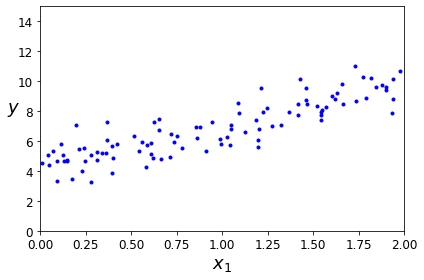

In [7]:
# Create a scatter plot of the randomly generated data
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15]) # Axis limits
save_fig('01_generated_data_plot')

Will now compute the values of $\theta$ for this dataset using the normal equation to prove that it does, indeed, derive the correct values. `np.linalg.inv` is used to invert the matrix and `dot` is used for matrix multiplication in the evaluation of  $$\theta^{'} = (X^{T}X)^{-1}X^{T}y$$

In [8]:
# Add the bias feature x_0 = 1 to all rows in X
X_b = np.c_[np.ones((100, 1)), X]

In [9]:
# Use the normal equation to find the values of theta for this model
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [10]:
theta_best

array([[4.21509616],
       [2.77011339]])

The reason why the normal equation does not predict exactly 4 and 3 is because we have added random noise to the value computed by the original function.

In [11]:
# Create new instances on which to test the normal equation
X_new = np.array([[0], [2]])

# Add x_0 = 1 to each instance
X_new_b = np.c_[np.ones((2, 1)), X_new] 

# Make predictions
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure  02_linear_model_predictions_plot


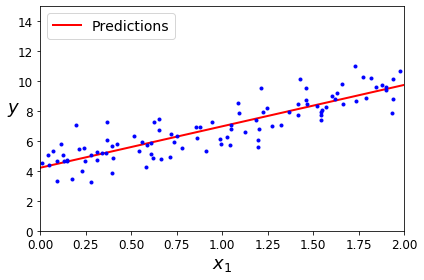

In [11]:
# Plot the model's predictions for all values in the domain
plt.plot(X_new, y_predict, 'r-', label='Predictions', linewidth=2)

# Original scatterplot data
plt.plot(X, y, 'b.')

plt.axis([0, 2, 0, 15])
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.legend(loc='upper left', fontsize=14)
save_fig('02_linear_model_predictions_plot')
plt.show()

## Example 2 - Linear Regression with `sklearn`

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lin_reg = LinearRegression()

In [14]:
# Computes the values of theta_0 and theta_1 that minimise MSE for X
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [15]:
# Output the learnt params 
print("Intercept: ", lin_reg.intercept_)
print("Coefficients: ", lin_reg.coef_)

Intercept:  [4.21509616]
Coefficients:  [[2.77011339]]


In [16]:
# Make predictions on new data using the linear regression model
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

 Under the hood, the `LinearRegression.fit()` method calls the least squares minimising function built into `scipy`, which we can call directly. It returns the least squares solution to a linear matrix equation.

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [18]:
theta_best_svd

array([[4.21509616],
       [2.77011339]])

Gives the same results as the linear regression function, but at a lower level of abstraction. Also, doesn't compute the inverse, but rather the pseudoinverse of X. The equation it solves is $$\theta^{'} = X^{+}y$$ where $X^{+}$ is the pseudoinverse of $X$.

In [19]:
# Can compute pseudoinverse and its dot product with y directly
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### Pseudoinverse vs Inverse
Pseudoinverse computation is done using **singular value decomposition (SVD)**, which decomposes a training set matrix **X** into the multiplication of three matrices $U$, $\Sigma$, $V^{T}$. 

The pseudoinverse uses $X^{+} = V \Sigma^{+}U^{T}$. To compute $Sigma^+$, the algorithm will set to 0 all values in $\Sigma$ that are lower than a specified threshold. Non-zero values are replaced with their inverses. The resulting matrix is then transposed. 

This provides a more **computationally efficient approach** than computing the actual inverse as in the normal equation, and also handles edge cases very wel. 

## Batch Gradient Descent

In [20]:
eta = 0.1         # Learning rate
n_iterations = 1000    # Number of steps until convergence assumed
m = 100           # Number of training samples in the batch 

In [21]:
theta = np.random.randn(2, 1) # Random initialisation of weights

In [22]:
for iteration in range(n_iterations):
    # Computing the gradient using entire batch - bias feature x_0 = 1 included
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y) 
    
    # Updating parameters by moving in the direction of steepest descent
    theta = theta - eta * gradients

In [23]:
theta

array([[4.21509616],
       [2.77011339]])

Gives the same values for `theta_0` and `theta_` as the linear regression model we implemented earlier (both with `sklearn` and with normal equation).

In [24]:
# Predictions made for a new data point will also be the same as earlier
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

## How does learning rate affect BGD?

Showing the first 10 steps of gradient descent with different learning rates. Updates values of theta, and then uses those values to plot a straight line at each step.

In [25]:
theta_path_bgd = []

In [26]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b) # Number of features
    plt.plot(X, y, 'b.') # Scatterplot of training samples
    n_iterations = 100
    
    # At every iteration
    for iteration in range(n_iterations):
        # For the first 10 iterations
        if iteration < 10:
            # Make predictions using the last updated values of theta
            y_predict = X_new_b.dot(theta)
            
            # The first prediction will be shown as a red line
            style = 'b-' if iteration > 0 else 'r--'
            
            # All other predictions will be shown as blue lines
            plt.plot(X_new, y_predict, style)
            
        # Compute the gradient for the next update of theta
        gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
        
        # Update theta
        theta = theta - eta * gradients
        
        # If there are already some values in theta_path, append the new theta updated values to it
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel('$x_1$', fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r'$\eta = {}$'.format(eta), fontsize=16)

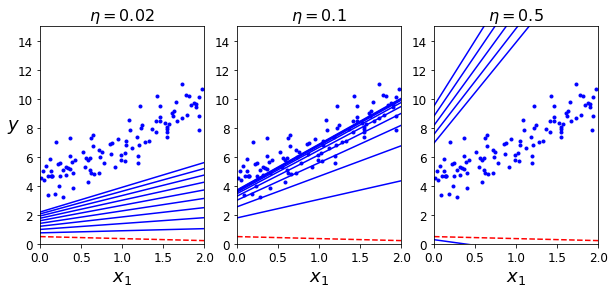

In [27]:
np.random.seed(42)
theta = np.random.randn(2, 1)
plt.figure(figsize=(10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5);

The first plot shows what happens when the learning rate is too low: the model will probably converge to the right values of theta, but will take too many iterations to do so.

The second plot shows what happens when the learning rate is "just right": it has already converged to the scatterplot in 10 iterations.

When the learning rate is too large (as in the third plot), the model actually diverges: it moves farther away from the scatterplot at each iteration.

Because the author knew that the optimal values of theta would be obtained with a learning rate of 0.1, he has chosen to save the values of theta with learning rate = 0.1 in `theta_path_bgd` so that they can be plotted later on.

## How to set iterations?
- Specify a very large number of iterations to start with.
- Calculate the magnitude of the gradient vector.
- Specify a threshold value $\epsilon$ - called the **tolerance**.
- When the magnitude of the gradient vector becomes less than the threshold $\epsilon$, the weights aren't really being updated substantially. This indicates that the model has converged. 
- Record the iterations at which this convergence aoccurs.

## Stochastic Gradient Descent
The problem with batch gradient descent is that it uses **all** the samples in the training set to compute the gradient vector and update parameters. This means that if the training set is very large, a single update will be computationally very expensive and therefore the entire process of training the model will be very slow.

Another way of updating weights is to pick a training sample at random from the data set and use it in computing the gradient. This is **stochastic** gradient descent. Because it uses only a single training sample, gradient computation is much faster and requires much less memory (which is why it can be implemented in an out of core leraning algorithm). 

However, because the sample is drawn at random, the weights are not updated in an organized systematic fashion. There is a lot of noise in the path taken by the parameters to converge. Even when it reaches near the global optimum, it will not settle on a single value, but continue to bounce around. **This isn't always a bad thing**: this can help the SGD algorithm escape local minima in highly irregular cost functions. 

### TLDR
- **Good**: Can escape local minima.
- **Bad**: Will never settle at a minimu,

### Solution - Learning Schedules
Gradually adjust the learning rate so that it is initially large, which will help the model escape local minima at first, and then decreases as the model approaches the global minimum, allowing it to settle. 

If the learning schedule decreases the learning rate too quickly, then the weights may get stuck at a local minimum or never reach a minimum to begin with (since updates are too small).

If the learning schedule decreases the learning rate too slowly, then the weights may jump around the minimum for a long time before converging.

In [28]:
# Used to store the weight updates for the optimal learning schedule with SGD
theta_path_sgd = []

In [29]:
# Number of features
m = len(X_b)

# Seeding random number generator to match book's results
np.random.seed(42)

In [30]:
# Can think of this as the number of iterations/full passes over the training st
n_epochs = 50

t_0, t_1 = 5, 50 # Learning schedule hyperparameters

In [31]:
def learning_schedule(t):
    # Returns a coefficient for scaling the learning rate at time `t`
    return t_0 / (t + t_1)

In [32]:
# Random initialization
theta = np.random.randn(2, 1)

[0, 2, 0, 15]

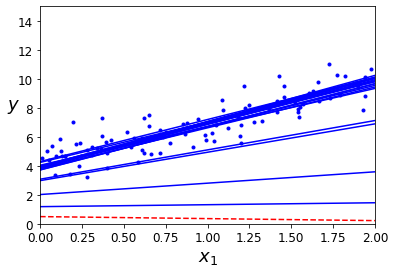

In [33]:
# For every epoch
for epoch in range(n_epochs):
    # Draw as many samples for SGD as there are samples in the training set
    for i in range(m):
        # For the first 20 samples in the first epoch
        if epoch == 0 and i < 20:
            # The prediciton using random initialised values of theta will be shown in red
            # For all others, show blue line
            y_predict = X_new_b.dot(theta)
            style ='b-' if i > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        
        # Generate index of sample to draw from training set to update weights
        random_index = np.random.randint(m)
        
        # Draw sample and its label
        x_i = X_b[random_index:random_index + 1]
        y_i = y[random_index:random_index + 1]
        
        # Compute the gradient using this sample
        gradients = 2 * x_i.T.dot(x_i.dot(theta) - y_i)
        
        # Calculate the learning rate as a function of the sample and epoch number
        # Later epochs and later samples will have lower learning rates
        eta = learning_schedule(epoch * m + i)
        
        # Update the params, append to theta_path_sgd
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

# Superimpose scatterplot of training data
plt.plot(X, y, 'b.') # B dot. Not b. Need to make a scatter plot
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

In [34]:
# What is the last value of theta calculated with SGD
theta

array([[4.21076011],
       [2.74856079]])

### Discussion
- The BGD algorithm took 1,000 iterations or iterated 1,000 times through the whole training set.
- SGD goes through the training set only 50 times before converging to a good solution.
    - 50 epochs or passes over the training set, and we already have convergence.
- Just because SGD iterates over `m` training samples **does not mean** that **all** samples in the training set will have been drawn at least once to update weights. Some samples may have been drawn more than once. Others may not have been drawn at all.
- If we want to ensure that all samples are drawn at least once, shuffle the data at each iteration in an epoch, and then generate a random index. However, this will converge more slowly. 

## SGD with `sklearn`

In [35]:
from sklearn.linear_model import SGDRegressor

The following `SGDRegressor` uses the mean-squared error as a loss function. It is set to iterate over the training set 1000 times, and will stop iterating as soon as magnitude of the loss between two iterations changes by less than 0.001. It does not implement any regularization, since `penalty` is `None`. The initial learning rate `eta0` is 0.1, and the learning schedule it uses to change the learning rate is different from the one we've implemented earlier. 

In [36]:
sgd_reg = SGDRegressor(loss='squared_loss', max_iter=1000, tol=1e-3, penalty=None, 
                      eta0=0.1, random_state=42)

In [37]:
# Why are we using y.ravel()
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [38]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

These values for `theta_0` and `theta_1` are both very close to the ones estimated by the normal equation. 

## Minibatch Gradient Descent

In [39]:
# Store weight updates for minibatch gradient descent to compare against other GDs
theta_path_mgd = []

In [40]:
n_iterations = 50

In [41]:
minibatch_size = 20

In [42]:
# Defining a function that will be used to update the learning rate 
t_0, t_1 = 200, 1000
def learning_schedule(t):
    return t_0 / (t + t_1)

In [43]:
# Initializing t
t = 0

In [44]:
np.random.seed(42)

In [45]:
# Random initialization of weights
theta = np.random.randn(2, 1)

In [46]:
for epoch in range(n_iterations):
    # Why are we using the permutation command here? Why not np.random.
    shuffled_indices = np.random.permutation(m)
    
    # Shuffle training samples and labels
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    # Iterate over the minibatch, use it to compute weight updates and gradients
    for i in range(0, m, minibatch_size):
        # Increment learning schedule counter variable
        t += 1
        x_i = X_b_shuffled[i : i + minibatch_size]
        y_i = y_shuffled[i : i + minibatch_size]
        
        # Denom is now the minibatch's size
        gradients = 2 / minibatch_size * x_i.T.dot(x_i.dot(theta) - y_i)
        
        # Update the learning rate for this iteration
        eta = learning_schedule(t)
        
        # Update the parameter weigths
        theta = theta - eta * gradients
        
        # Record the param updates
        theta_path_mgd.append(theta)

In [47]:
# What is the final value of theta derived from SGD?
theta

array([[4.25214635],
       [2.7896408 ]])

## Comparing Gradient Descent Variants

In [48]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure  gradient_descent_paths_plot


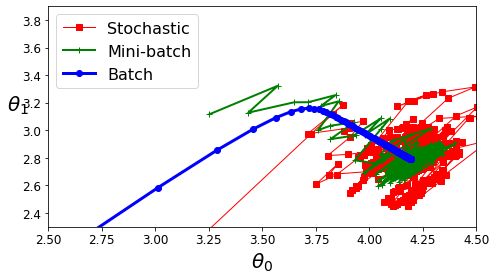

In [49]:
plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], 'r-s', 
        linewidth=1, label='Stochastic')
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], 'g-+', 
        linewidth=2, label='Mini-batch')
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], 'b-o', 
        linewidth=3, label='Batch')
plt.legend(loc='upper left', fontsize=16)
plt.xlabel(r'$\theta_0$', fontsize=20)
plt.ylabel(r'$\theta_1$', fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig('gradient_descent_paths_plot')

## Polynomial Regression
If data is too complex to be fit with a simple straight line, can use polynomial regression: make new features that are powers of existing linear model features (by multiplying a feature either by itself or by other features). Then fit a linear regression model that is based on these features. 

### Generating Nonlinear Features

In [17]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [18]:
# Number of training samples
m = 100

# Features are scalars between -3 and 3
X = 6 * np.random.rand(m, 1) - 3

# Labels are non-linear combinations of the features
# theta_0 = np.random.randn + 2
# theta_1 = 1
# theta_2 = 0.5
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

### Plotting the random data

Saving figure  quadratic_data_plot


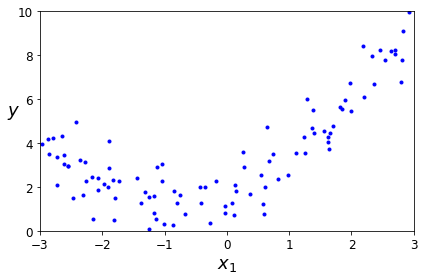

In [19]:
plt.plot(X, y, 'b.'); plt.xlabel('$x_1$', fontsize=18); 
plt.ylabel('$y$', fontsize=18, rotation=0);
plt.axis([-3, 3, 0, 10])
save_fig('quadratic_data_plot')

### Using `sklearn` to fit a polynomial model

In [20]:
from sklearn.preprocessing import PolynomialFeatures

In [21]:
# Generating a polynomial feature transformer - will create features with powers up to 2
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Then fit the transformer to the original features
X_poly = poly_features.fit_transform(X)

In [22]:
# Comparing the original and polynomial features
print("The first original feature is: ", X[0])
print("The first polynomial feature is: ", X_poly[0])

The first original feature is:  [-0.75275929]
The first polynomial feature is:  [-0.75275929  0.56664654]


In [23]:
# A polynomial model is just a linear model with polynomial features
from sklearn.linear_model import LinearRegression

In [24]:
# Instantiate
lin_reg = LinearRegression()

# Fit to polynomial features
lin_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Comparing Fit to Original Data

In [25]:
# Domain
X_new = np.linspace(-3, 3, 100).reshape(100, 1)

# Features, including polynomial ones - reusing the transformer
X_new_poly = poly_features.transform(X_new)

# Predictions will be made using learnt values of theta
y_new = lin_reg.predict(X_new_poly)

Saving figure  quadratic_predictions_plot


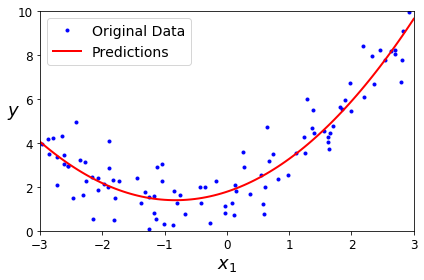

In [26]:
# Original data scatterplot
plt.plot(X, y, 'b.', label='Original Data')
plt.plot(X_new, y_new, 'r-', linewidth=2, label='Predictions')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig('quadratic_predictions_plot')

In [89]:
# What values of parameters have been learnt?
print("Intercept: ", lin_reg.intercept_) 
print("Coefficients: ", lin_reg.coef_)

Intercept:  [1.78134581]
Coefficients:  [[0.93366893 0.56456263]]


This means that the polynomial regression model learnt through this data is $$y' = 1.7813 + 0.9336x_1 + 0.5645x_2$$
which is not that different from the original model $$y = 2 + rand + x_1 + 0.5x_2$$

Another advantage of polynomial regression is that it can often find combinations of existing features that can often help find the best fit to to data. For instance, a polynomial model of degree 3 based on features `x_1, x_2, x_3` will not just have features `x_1, x_1^2, x_1^3` but also `x_1.x_2.x_3`, and all combinations of features up to degree 3.

## Learning Curves, Overfitting, Underfitting

### Comparing 300-degree polynomial model
Training a higher degree polynomial model will likely result in a model that fits the training data very well, but won't necesssarily mean that this model is a good predictor on data it hasn't seen before.

Comparing the performance of a simple linear regression model, a 2 degree linear regression model, and a 300 degree linear regression model.

In [27]:
# Seeding random number generator, just in case
np.random.seed(42)

In [28]:
# Importing required libraries
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [29]:
# Instantiating original data for all models
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [30]:
# Creating a list of all models to train and plot with degrees and styles
model_list = (('g-', 1, 300), ('b--', 2, 2), ('r-+', 2, 1))

Saving figure  high_degree_poly_plot


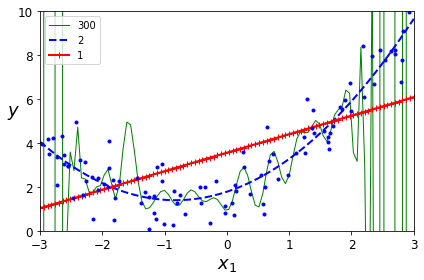

In [31]:
for style, width, degree in model_list:
    # Instantiate polynomial feature transformer of the right degree
    poly_big_features = PolynomialFeatures(degree=degree, include_bias=False)
        
    # Instantiate standard scaler (b/c different degrees -> different ranges of feature values)
    standard_scaler = StandardScaler()
    
    # Instantiate a generic linear regression model
    lin_reg = LinearRegression()
    
    # Create a pipeline that transforms to polynomial features, scales them, and uses the to fit a lin model
    polynomial_regression = Pipeline([
        ('poly_features', poly_big_features),
        ('std_scaler', standard_scaler),
        ('lin_reg', lin_reg)
    ])
    
    # Fit the model after performing the transformation defined in the pipeline
    polynomial_regression.fit(X, y)

    # Record predictions
    y_new_big = polynomial_regression.predict(X_new)
    
    # Plot
    plt.plot(X_new, y_new_big, style, label=str(degree), linewidth=width)

    
# Plot the original data
plt.plot(X, y, 'b.', linewidth=3)
plt.legend(loc='upper left')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.axis([-3, 3, 0, 10])
save_fig('high_degree_poly_plot')

It is obvious that the quadratic model fits the data best, and that the 300 degree and 1 degree polynomials overfit and underfit the data respectively. Intuitively, this makes sense since we know the original data was generated using a quadratic function.

But IRL, we won't often know what function was used to create data (or if such a function even exists). We will also not necessarily be able to plot data in this way to see if a model curves or 'wiggles' too much or too little to fit the data. So how to confirm underfitting or overfitting? 

The solution is to use learning curves: plot the model's performance on training and validation sets as a function of training set size (or the training iteration).

## Case 1 - Underfitting

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [33]:
np.random.seed(42)

In [34]:
def plot_learning_curves(model, X, y):
    """Generic function to plot supervised learning curves for a model given X and y"""
    # Perform a train-test split - RANDOM STATE IS IMPORTANT FOR REPRODUCABILITY
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Separate lists to store training and validation set errors
    train_errors, val_errors= [], []
    
    # Train the model on increasingly larger training sets, and plot errors
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        # Training predictions over the first `m` samples only
        y_train_predict = model.predict(X_train[:m])
        
        # Validation predictons on the entire set
        y_val_predict = model.predict(X_val)
        
        # Add training error for this size by comparing the first `m` predictions to lables
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        
        # Add validation error for this size
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    # Plot the training and validation errors
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train RMSE')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val RMSE')
    
    # Annotate the plot
    plt.legend(loc='upper right', fontsize=14);
    plt.xlabel('Training Set Size', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)

[0, 80, 0, 3]

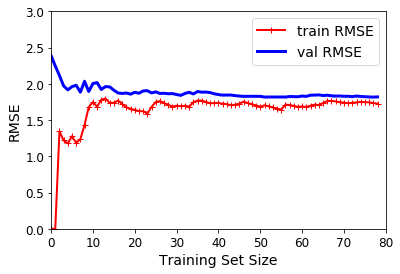

In [35]:
# Instantiate a model to plot learning curves for 
lin_reg = LinearRegression()

# Pass the model to the function along with its trainin set
plot_learning_curves(lin_reg, X, y)

# Annotate
plt.axis([0, 80, 0, 3])

### Interpretation - Underfitting
- Training loss is initially very low because there are only a few training samples in the data, which means it isn't difficult for the learning algorithm to modify model parameters to fit all points.
- As training set size grows, there are more points to fit, and eventually the model cannot fit all of them perfectly, hich is why the loss begins to increase.
- Eventually, though, adding additional data points does not substantially change the average error in the training model, which is why it has plateaued. 
- Initial validation loss is high because when the model is trained on only a few samples, its parameters haven't been updated substantially to fit the data.
- Eventually, as more samples are added, the model moves closer to its optimal parameters through gradient descent updates.
- Validation loss also plateaus after a while because the model's weights are no longer being updated substantially enough by gradient descent, because they're already close enough to optimal model.

### Underfitting: Validation and Training Loss are fairly high and close together.
- Adding more training examples will not help.
- Need a more complex model.
- Need feature engineering.

## Case 2 - Overfitting
Fitting a 10 degree polynomial to the data and plotting its training and validation RMSEs. When fitting a 10 degree polynomial to data that was originally generated using 2nd degree polynomial, there will obviously be a lot of overfitting: the model will try to find patterns that don't exist because it has to optimise more parameters than are necessary to fit the data.

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [40]:
# Instantiate pipeline that will fit 10 degree polynomial features to a lin reg model
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)), 
    ("lin_reg", LinearRegression()), 
])

Saving figure  learning_curves_overfitting_plot


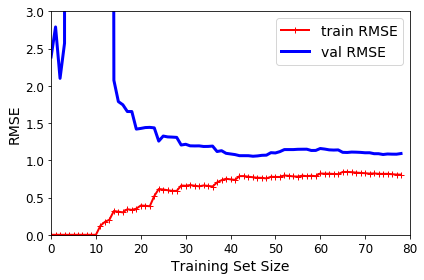

In [41]:
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]) 
save_fig('learning_curves_overfitting_plot')

## Interpretation
- Error in both training and validation sets is much lower than in the previous learning curves. 
- There is a significant gap between the curves, indicatng that the model performs significantly better on training data than on valiation data, which is a hallmark of **overfitting** 
- Solution: use regularization, or a much larger training set.

## Bias Variance Tradeoff
There are **three** major components of the generalization error in a Machine Learning model
- **bias**: incorrect assumptions about the nature of the model e.g. the error introduced by trying to fit a linear model to quadratic data. Models with high bias are likely to underfit the data, and increasing the number of training samples will not improve the models performance.
- **variance**: the sensitivity of the model to small variations in data, or how much the model's parameter values are likely to vary between trainings with different subsets of the training data. A model with many degrees of freedom is likely to have high variance, which means its performance could be improved by regularizing features, decreasing the complexity of the model, or increasing the number of training examples.
- **irreducible error**: error that cannot be eliminated and is due to the inherent noisiness of the data itself.

As model complexity increases, its variance increases but bias decreases. As model complexity decreases, its bias increases but variance decreases.

The optimal model will strike a balance between bias and variance - thus achieving an optimal bias-variance tradeoff.

## Regularized Linear Models
A simple way of regularizing polynomial models is to decrease the degree of the polynomial, which in turn decreases the degrees of freedom.

We can also constrain the weights of the model to take smaller values. Three methods of doing so
- Ridge Regression
- Lasso Regression
- Elastic Net

All three constrain the weights in different ways.

## Ridge Regression
Modify the cost function so that in addition to minimising the the cost `MSE` i.e. the mean-squared error of the difference between predicted and actual values, the cost function also has to minimise the sum of the weight vector `w` scaled by a regularization factor `alpha`. 

This means the values of the parameters are constrained to be smaller, which minimises variance (but increases bias).

### Ridge Regression Visualization

In [6]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [19]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [20]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    """Plots regularized linear and polynomial regression models"""
    # For three possible valus of regularization coeff, each with their own color and plotting marker
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        # Instantiate a model with the correct params if positive alpha, else make a lin reg model
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        
        # If called with polynomial arg flag set to True
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()), # Must scale features b/c regularization sensitive to outliers
                ('regul_reg', model)
            ])
        
        # Fit the model, regardless of type
        model.fit(X, y)
        
        # Store regularized predictions
        y_new_regul = model.predict(X_new)
        
        # Set linewidth according to regularization rate
        lw = 2 if alpha > 0 else 1
        
        # Plot the regularized model
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r'$\alpha = {}$'.format(alpha))
        
        # Also plot scatter data for original samples
        plt.plot(X, y, 'b.', linewidth=3)
        
        # Annotate
        plt.legend(loc='upper left', fontsize=18)
        plt.xlabel('$x_1$', fontsize=18)
        plt.ylabel('$y$', rotation=0, fontsize=18)
        plt.axis([0, 3, 0, 4])

Saving figure  ridge_reg_lin_poly


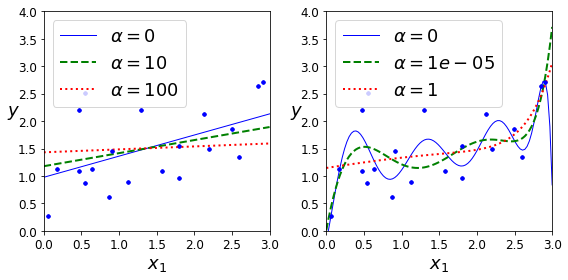

In [21]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.tight_layout()
save_fig('ridge_reg_lin_poly')

The left plot shows linear ridge regression models for with varying levels of regularization. With regularization coefficient set to 0, the model is simply a straight line and is identical to a standard linear regression model. As the regression coefficient increases, the model comes closer and closer to a straight line, because the cost function prioritises minimising weights to minimise the regularization term rather than minimising the loss itself. 

The right plot shows the effect of ridge regression on polynomial models. With no regularization, the model has high variance. As regularization increases, the degrees of freedom (and variance) of the model decrease. With regularization coefficient set to 1, the model has the best fit to the scatterplot data.

### Ridge Regression - Analytical Solution
As with linear regression, ridge regression model's parameters can be derived analytically through a mathematical equation. 

$$\theta' = (X^T.X + \alpha A)^{-1}X^Ty$$

In [22]:
# Can solve this using sklearn
from sklearn.linear_model import Ridge
ridge_reg_closed_form = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg_closed_form.fit(X, y)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001)

In [23]:
ridge_reg_closed_form.predict([[1.5]])

array([[1.55071465]])

In [24]:
# Can also use SGDRegressor
from sklearn.linear_model import SGDRegressor

In [26]:
sgd_reg = SGDRegressor(penalty='l2', random_state=42, 
                      max_iter=1000, tol=1e-3) # L2 norm used for computing regularization term
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### Lasso Regression
- **LASSO** - **L**east **A**bsolute **S**hrinkage **a**nd **S**election **O**perator regression
- A different kind of regularization, just like ridge regression.
- Adds a regularization term to the cost function.
- But this time the regularization term is the L1 norm of the weight vector instead of half the square of the L2 norm. 

In [27]:
from sklearn.linear_model import Lasso

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Saving figure  lasso_regression_plot


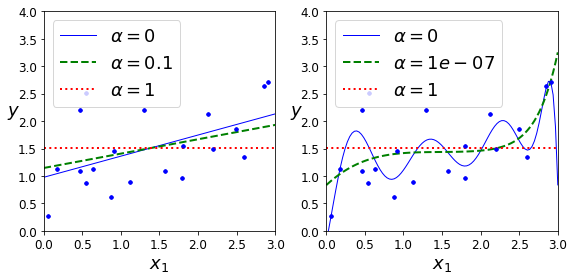

In [30]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
save_fig('lasso_regression_plot', tight_layout=True)

The difference between ridge and lasso regression is the nature of the norm used in the regularization term. Ridge regression uses the L2 norm while lasso regression uses the L1 norm. 

The result of this difference is that lasso regression tends to eliminate the weights of the least important features. This is why the model with `alpha` set to `1e-07` is almost linear for the majority of the feature space: the weights of higher order polynomial terms have been eliminated. 

In [33]:
# Using sklearn's Lasso class
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net
- A regularization technique that is a mix of both ridge regression and lasso regression.
- Need to specify the regularization mix `r` which, in turn, determines whether the cost function is "more like" ridge regression or lasso regression.
    - As `r` -> 0, Elastic Net behaves more like ridge regression, which minimises the weights of **all** features. 
    - As `r` -> 1, Elastic Net behaves more like lasso regression, which eliminates the weights of irrelevant featurese entirely.
- Ridge regression is a good default, but if you suspect lots of redundant, irrelevant, or correlated features, use lasso or elastic net regression.
    - Elastic net regression is preferred because lasso may behave erratically when the number of features is greater than the number of training instances, or when several features are strongly correlated.

## Early Stopping
Stop training after the validation set error is observed to reach a minimum i.e. when changes in validation set error become smaller than some threshold value. This is easiest to do with batch gradient descent, because parameter updates (and thus the error updates) are consistent and smooth.

With stochastic or minibatch gradient desent, the loss will show a lot of noise. Better to wait for noise to be consistently low for a fixed number of epochs, and then roll back weights to the first instance/epoch at which these weights were seen.

In [42]:
# Setting up data set for early stopping example
np.random.seed(42)
m = 100 
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X ** 2 + np.random.randn(m, 1)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), 
                                                  test_size=0.5, random_state=10)

In [52]:
from sklearn.base import clone
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [36]:
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)), 
    ('std_scaler', StandardScaler()),
])

In [47]:
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [50]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, 
                      penalty=None, learning_rate='constant', eta0=0.0005, random_state=42)

In [53]:
minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    # Continue training from the last epoch or epoch where we left off 
    sgd_reg.fit(X_train_poly_scaled, y_train)
    
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error 
        best_epoch = epoch
        best_model = clone(sgd_reg)

Saving figure  early_stopping_visualization


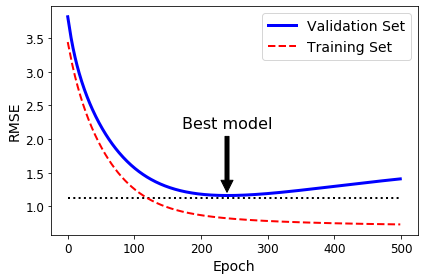

In [56]:
# Create graph for sgd regression over different epochs
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, # To start training where it left off
                      penalty=None, learning_rate='constant', eta0=0.0005, random_state=42)

n_epochs = 500

# Store training and validation errors for each epoch in separate lists
train_errors, val_errors = [], []

# For every epoch, do an additional round of training and remember the train + val MSE
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    
# Find the epochs for which we get the least RMSE 
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
            xy=(best_epoch, best_val_rmse), 
            xytext=(best_epoch, best_val_rmse + 1), 
            ha='center', 
            arrowprops=dict(facecolor='black', shrink=0.05), 
            fontsize=16)

# Doing this just to make the graph look better
best_val_rmse -= 0.03 

# Draw a straight, dotted, horizontal line at the best (least) RMSE
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], 'k:', linewidth=2)

# Plot the training RMSE against number of epochs
plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='Validation Set')
plt.plot(np.sqrt(train_errors), 'r--', linewidth=2, label='Training Set')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
save_fig('early_stopping_visualization')

In [57]:
# What are the parameters for the best model?
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

This shows that if we trained a simple SGD regressor to fit this specific data, we should stop training after 239 epochs because that is when the validation set loss reaches its minimum value.

This is the same as regularization, because we're preventing overfitting by stopping training before the model starts to update its weights to match minute, inconsequential patterns in the data.